In [5]:
# =============================================================================
# Steel Plate Defect Prediction - Complete Classification Pipeline
# =============================================================================

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

print("Steel Plate Defect Prediction - Classification Pipeline")
print("=" * 60)

# Load the competition data
print("Step 1: Loading Competition Data...")

# Load datasets (download these from Kaggle first)
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display basic information
print("\nTraining data info:")
print(train_data.info())
print("\nFirst few rows:")
print(train_data.head())


Steel Plate Defect Prediction - Classification Pipeline
Step 1: Loading Competition Data...
Training data shape: (19219, 35)
Test data shape: (12814, 28)
Sample submission shape: (12814, 8)

Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11 


Step 2: Exploratory Data Analysis...
Target column identified: Other_Faults
Target distribution:
Other_Faults
0    12661
1     6558
Name: count, dtype: int64


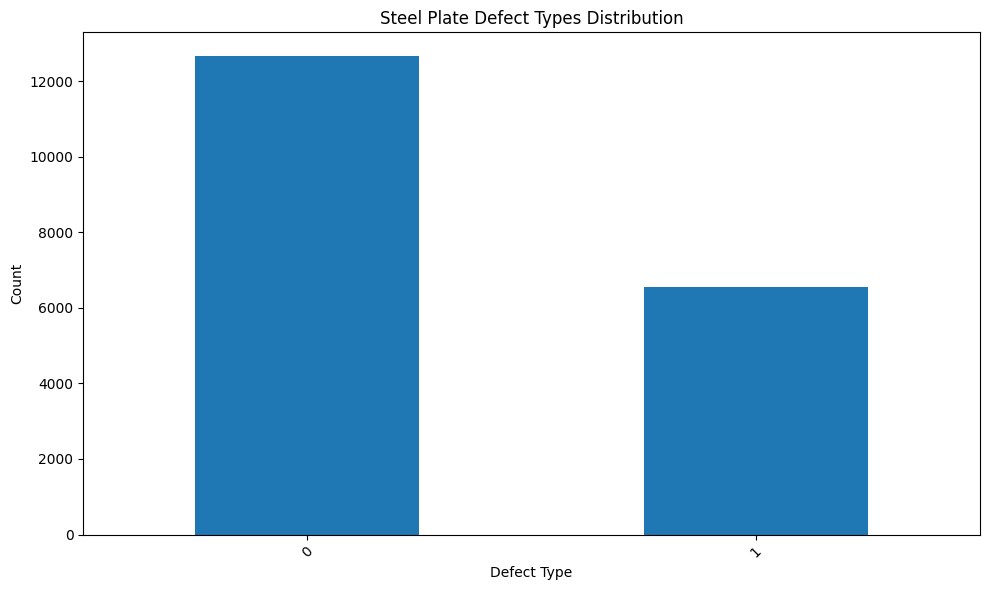


Number of features: 34
Feature columns: ['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity'] ...

Missing values in training data:
No missing values

Missing values in test data:
No missing values

Feature statistics:
                 id     X_Minimum     X_Maximum     Y_Minimum     Y_Maximum  \
count  19219.000000  19219.000000  19219.000000  1.921900e+04  1.921900e+04   
mean    9609.000000    709.854675    753.857641  1.849756e+06  1.846605e+06   
std     5548.191747    531.544189    499.836603  1.903554e+06  1.896295e+06   
min        0.000000      0.000000      4.000000  6.712000e+03  6.724000e+03   
25%     4804.500000     49.000000    214.000000  6.574680e+05  6.575020e+05   
50%     9609.000000    777.000000    796.000000  1.398169e+06  1.398179e+06   
75%    14413.500000   1152.000000   1165.000000  2.368032e+06  2.362511e+06   
max    19218.000000   1705.000000   1713.000000  1.

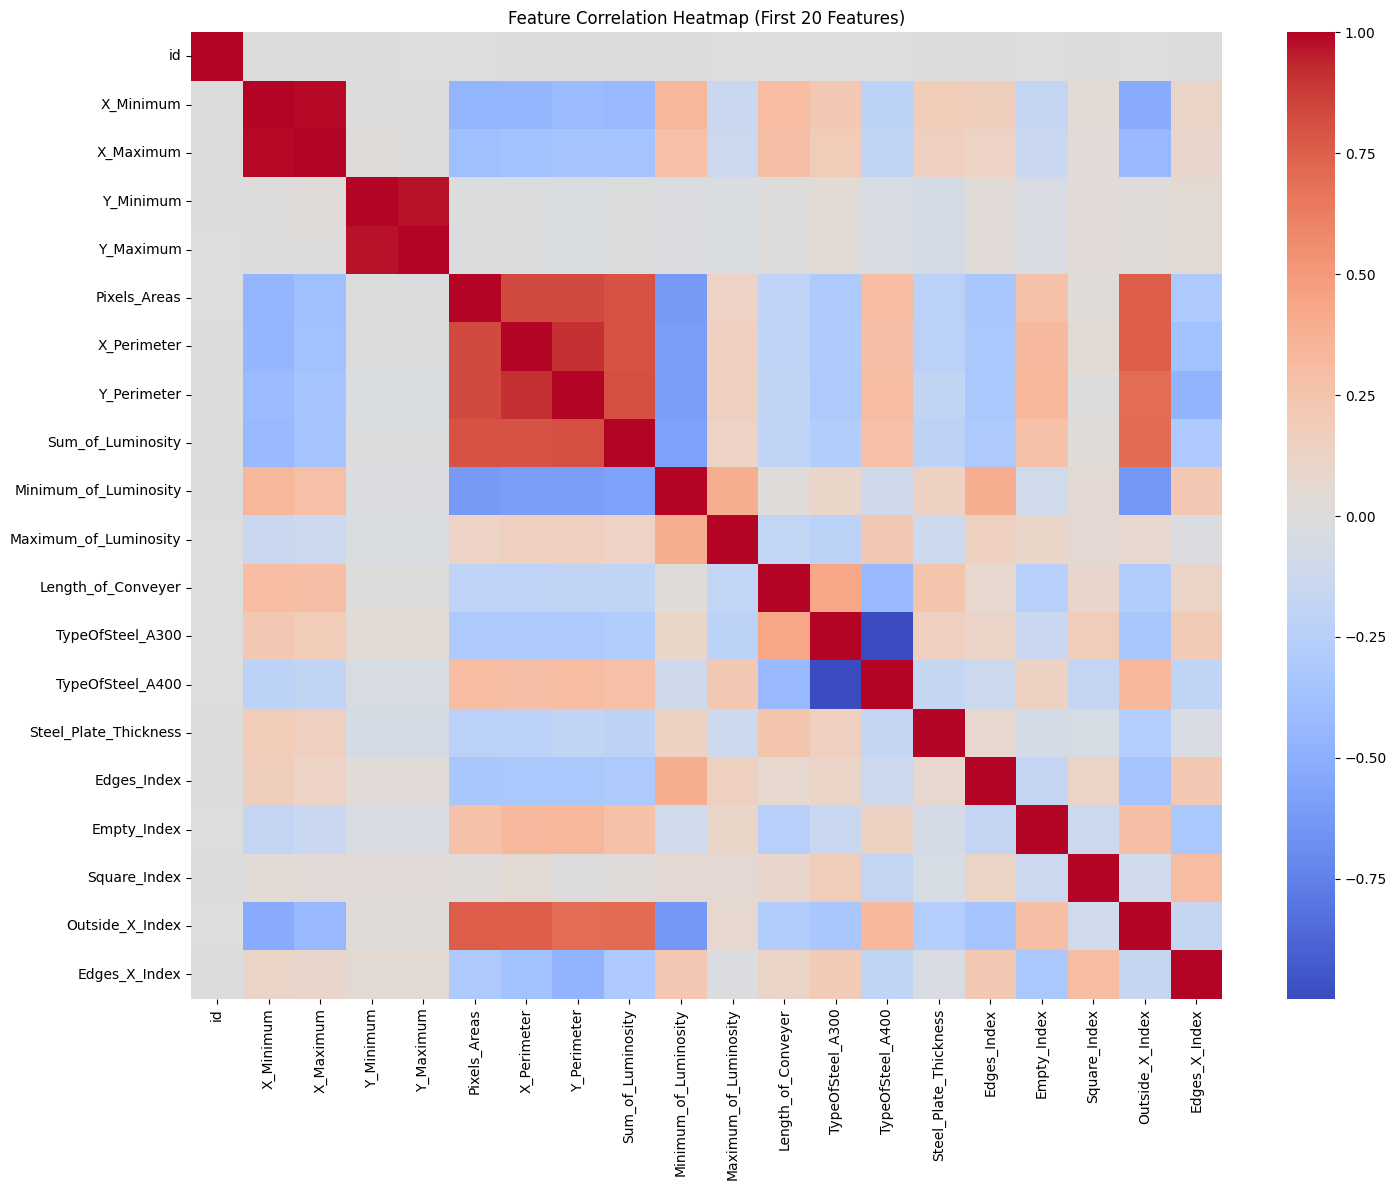

In [6]:
# =============================================================================
# Step 2: Exploratory Data Analysis
# =============================================================================

print("\nStep 2: Exploratory Data Analysis...")
print("=" * 50)

# Check target variable (assuming it's in the last column or named 'target')
# Steel plate defect competitions typically have multiple defect types
target_col = [col for col in train_data.columns if col.lower() in ['target', 'class', 'defect']]
if not target_col:
    # If no obvious target, assume last column
    target_col = train_data.columns[-1]
else:
    target_col = target_col[0]

print(f"Target column identified: {target_col}")
print(f"Target distribution:")
print(train_data[target_col].value_counts().sort_index())

# Visualize target distribution
plt.figure(figsize=(10, 6))
train_data[target_col].value_counts().sort_index().plot(kind='bar')
plt.title('Steel Plate Defect Types Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature analysis
feature_cols = [col for col in train_data.columns if col != target_col]
print(f"\nNumber of features: {len(feature_cols)}")
print("Feature columns:", feature_cols[:10], "..." if len(feature_cols) > 10 else "")

# Check for missing values
print(f"\nMissing values in training data:")
missing_train = train_data.isnull().sum()
print(missing_train[missing_train > 0] if missing_train.sum() > 0 else "No missing values")

print(f"\nMissing values in test data:")
missing_test = test_data.isnull().sum()
print(missing_test[missing_test > 0] if missing_test.sum() > 0 else "No missing values")

# Basic statistics
print(f"\nFeature statistics:")
print(train_data[feature_cols].describe())

# Correlation heatmap for first 20 features
plt.figure(figsize=(15, 12))
correlation_matrix = train_data[feature_cols[:20]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (First 20 Features)')
plt.tight_layout()
plt.show()


In [7]:
# =============================================================================
# FIXED Step 3: Data Preprocessing and Feature Engineering
# =============================================================================

print("Step 3: Data Preprocessing and Feature Engineering...")
print("=" * 60)

# Debug: Check column differences between train and test
print("Debugging column mismatch...")
print(f"Training data columns ({len(train_data.columns)}): {list(train_data.columns)}")
print(f"Test data columns ({len(test_data.columns)}): {list(test_data.columns)}")

# Find common columns between train and test (excluding target)
train_cols = set(train_data.columns)
test_cols = set(test_data.columns)
common_cols = train_cols.intersection(test_cols)

print(f"\nCommon columns: {len(common_cols)}")
print(f"Columns only in train: {train_cols - test_cols}")
print(f"Columns only in test: {test_cols - train_cols}")

# Identify target column more carefully
# Steel plate defect datasets typically have multiple binary target columns
possible_targets = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
actual_targets = [col for col in possible_targets if col in train_data.columns]

if not actual_targets:
    # If no typical defect names found, look for binary columns
    potential_targets = []
    for col in train_data.columns:
        if col not in test_data.columns:
            unique_vals = train_data[col].nunique()
            if unique_vals <= 10:  # Likely categorical/target
                potential_targets.append(col)
    actual_targets = potential_targets

print(f"\nIdentified target columns: {actual_targets}")

# For steel plate defect, this is typically a multi-label or single multi-class problem
# Let's handle both cases

if len(actual_targets) == 1:
    # Single target column
    target_col = actual_targets[0]
    y = train_data[target_col].copy()
    print(f"Single target problem: {target_col}")
    print(f"Target distribution:\n{y.value_counts()}")
    
elif len(actual_targets) > 1:
    # Multi-label problem - convert to single label
    print(f"Multi-label problem with {len(actual_targets)} targets")
    print("Converting to single multi-class target...")
    
    # Create combined target
    target_combinations = train_data[actual_targets].apply(
        lambda row: '_'.join([col for col, val in zip(actual_targets, row) if val == 1]), 
        axis=1
    )
    target_combinations = target_combinations.replace('', 'No_Defect')
    
    y = target_combinations.copy()
    target_col = 'combined_target'
    
    print(f"Combined target distribution:\n{y.value_counts()}")
    
else:
    # Fallback: assume last column in train that's not in test
    target_candidates = [col for col in train_data.columns if col not in test_data.columns]
    if target_candidates:
        target_col = target_candidates[-1]  # Take last one
        y = train_data[target_col].copy()
        print(f"Fallback target: {target_col}")
    else:
        raise ValueError("Could not identify target column!")

# Get feature columns (intersection of train and test, excluding ID)
feature_cols = [col for col in common_cols if col.lower() not in ['id', 'index']]
print(f"\nFeature columns ({len(feature_cols)}): {feature_cols[:10]}{'...' if len(feature_cols) > 10 else ''}")

# Prepare datasets
X = train_data[feature_cols].copy()
X_test = test_data[feature_cols].copy()

print(f"\nDataset shapes:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")
print(f"X_test: {X_test.shape}")

# Check for missing values
print(f"\nMissing values check:")
print(f"Training features: {X.isnull().sum().sum()} missing values")
print(f"Test features: {X_test.isnull().sum().sum()} missing values")
print(f"Target: {y.isnull().sum()} missing values")

# Handle missing values if any
if X.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("\nHandling missing values with median imputation...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Feature Engineering for Steel Plate Data
print("\nCreating engineered features...")

# Statistical features across all measurements
X['feature_mean'] = X.mean(axis=1)
X['feature_std'] = X.std(axis=1)
X['feature_min'] = X.min(axis=1)
X['feature_max'] = X.max(axis=1)
X['feature_range'] = X['feature_max'] - X['feature_min']
X['feature_median'] = X.median(axis=1)
X['feature_skew'] = X.skew(axis=1)

# Apply same transformations to test set
X_test['feature_mean'] = X_test.mean(axis=1)
X_test['feature_std'] = X_test.std(axis=1)
X_test['feature_min'] = X_test.min(axis=1)
X_test['feature_max'] = X_test.max(axis=1)
X_test['feature_range'] = X_test['feature_max'] - X_test['feature_min']
X_test['feature_median'] = X_test.median(axis=1)
X_test['feature_skew'] = X_test.skew(axis=1)

# Feature scaling
from sklearn.preprocessing import RobustScaler
print("\nApplying robust scaling...")
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"\nFinal shapes after preprocessing:")
print(f"X_scaled: {X_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y: {y.shape}")

# Encode target if it's categorical (for multi-class)
from sklearn.preprocessing import LabelEncoder

if y.dtype == 'object' or len(y.unique()) > 2:
    print("\nEncoding target variable...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    print(f"Target classes: {label_encoder.classes_}")
    print(f"Class distribution: {np.bincount(y_encoded)}")
else:
    y_encoded = y.copy()
    label_encoder = None
    print(f"\nBinary target - no encoding needed")
    print(f"Class distribution: {np.bincount(y_encoded)}")

print("\n✅ Data preprocessing completed successfully!")


Step 3: Data Preprocessing and Feature Engineering...
Debugging column mismatch...
Training data columns (35): ['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
Test data columns (28): ['id', 'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 

In [8]:
# =============================================================================
# FIXED Step 4: Train-Validation Split (Handling Rare Classes)
# =============================================================================

print("Step 4: Creating Train-Validation Split...")
print("=" * 50)

# Check class distribution first
print("Analyzing class distribution for stratification...")
class_counts = np.bincount(y_encoded)
rare_classes = []

print(f"{'Class':<25} {'Count':<8} {'Status'}")
print("-" * 45)

for i, (class_name, count) in enumerate(zip(label_encoder.classes_, class_counts)):
    status = "RARE" if count < 2 else "OK"
    print(f"{class_name:<25} {count:<8} {status}")
    if count < 2:
        rare_classes.append(i)

print(f"\nRare classes (count < 2): {len(rare_classes)}")

# Option 1: Remove rare classes
if len(rare_classes) > 0:
    print(f"\n⚠️  Handling rare classes...")
    print(f"Classes with only 1 sample: {[label_encoder.classes_[i] for i in rare_classes]}")
    
    # Remove samples with rare classes
    mask = ~np.isin(y_encoded, rare_classes)
    X_scaled_filtered = X_scaled[mask]
    y_encoded_filtered = y_encoded[mask]
    
    print(f"Original dataset: {X_scaled.shape[0]} samples")
    print(f"After removing rare classes: {X_scaled_filtered.shape[0]} samples")
    print(f"Removed: {X_scaled.shape[0] - X_scaled_filtered.shape[0]} samples")
    
    # Update label encoder to remove unused classes
    unique_classes = np.unique(y_encoded_filtered)
    new_classes = label_encoder.classes_[unique_classes]
    
    # Create new mapping
    class_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}
    y_encoded_remapped = np.array([class_mapping[label] for label in y_encoded_filtered])
    
    print(f"New number of classes: {len(new_classes)}")
    print(f"New classes: {new_classes}")
    
    # Update label encoder
    label_encoder_new = LabelEncoder()
    label_encoder_new.classes_ = new_classes
    
    # Use filtered data
    X_for_split = X_scaled_filtered
    y_for_split = y_encoded_remapped
    label_encoder = label_encoder_new
    
else:
    # No rare classes, use original data
    X_for_split = X_scaled
    y_for_split = y_encoded

# Now perform stratified split
print(f"\nPerforming stratified train-validation split...")

try:
    X_train, X_val, y_train, y_val = train_test_split(
        X_for_split, y_for_split, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_for_split
    )
    print("✅ Stratified split successful!")
    
except ValueError as e:
    print(f"⚠️  Stratified split failed: {e}")
    print("Falling back to random split...")
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_for_split, y_for_split, 
        test_size=0.2, 
        random_state=42, 
        stratify=None  # No stratification
    )
    print("✅ Random split completed!")

print(f"\nFinal split results:")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Show class distribution in splits
print(f"\nClass distribution in training set:")
train_dist = np.bincount(y_train)
for i, count in enumerate(train_dist):
    if count > 0:
        class_name = label_encoder.classes_[i]
        print(f"  {class_name}: {count}")

print(f"\nClass distribution in validation set:")
val_dist = np.bincount(y_val, minlength=len(label_encoder.classes_))
for i, count in enumerate(val_dist):
    if count > 0:
        class_name = label_encoder.classes_[i]
        print(f"  {class_name}: {count}")

# Update the global variables for next steps
y_encoded = y_for_split  # Use the filtered/remapped target
X_scaled = X_for_split   # Use the filtered features

print("\n✅ Train-validation split completed successfully!")
print(f"Working with {len(label_encoder.classes_)} classes")


Step 4: Creating Train-Validation Split...
Analyzing class distribution for stratification...
Class                     Count    Status
---------------------------------------------
Bumps                     4761     OK
Dirtiness                 485      OK
K_Scatch                  3411     OK
K_Scatch_Bumps            2        OK
K_Scatch_Other_Faults     18       OK
No_Defect                 818      OK
Other_Faults              6540     OK
Pastry                    1465     OK
Pastry_K_Scatch           1        RARE
Stains                    568      OK
Z_Scratch                 1150     OK

Rare classes (count < 2): 1

⚠️  Handling rare classes...
Classes with only 1 sample: ['Pastry_K_Scatch']
Original dataset: 19219 samples
After removing rare classes: 19218 samples
Removed: 1 samples
New number of classes: 10
New classes: ['Bumps' 'Dirtiness' 'K_Scatch' 'K_Scatch_Bumps' 'K_Scatch_Other_Faults'
 'No_Defect' 'Other_Faults' 'Pastry' 'Stains' 'Z_Scratch']

Performing stratified tra

Step 5: Building and Training Multiple Models...

 Training XGBoost...
XGBoost - Accuracy: 0.5783, F1-Score: 0.5566

 Training LightGBM...
LightGBM - Accuracy: 0.4155, F1-Score: 0.3985

 Training CatBoost...
CatBoost - Accuracy: 0.5786, F1-Score: 0.5586

 Training Random Forest...
Random Forest - Accuracy: 0.5671, F1-Score: 0.5532

📊 MODEL PERFORMANCE SUMMARY
Model           Accuracy     F1-Score    
---------------------------------------------
XGBoost         0.5783       0.5566      
LightGBM        0.4155       0.3985      
CatBoost        0.5786       0.5586      
Random Forest   0.5671       0.5532      
---------------------------------------------
🏆 Best Model: CatBoost (Accuracy: 0.5786)

📋 Classification Report for CatBoost:
Classes in validation set: 9
Classes in predictions: 8
Total unique classes: 9
                       precision    recall  f1-score   support

                Bumps       0.52      0.54      0.53       952
            Dirtiness       0.35      0.15      0

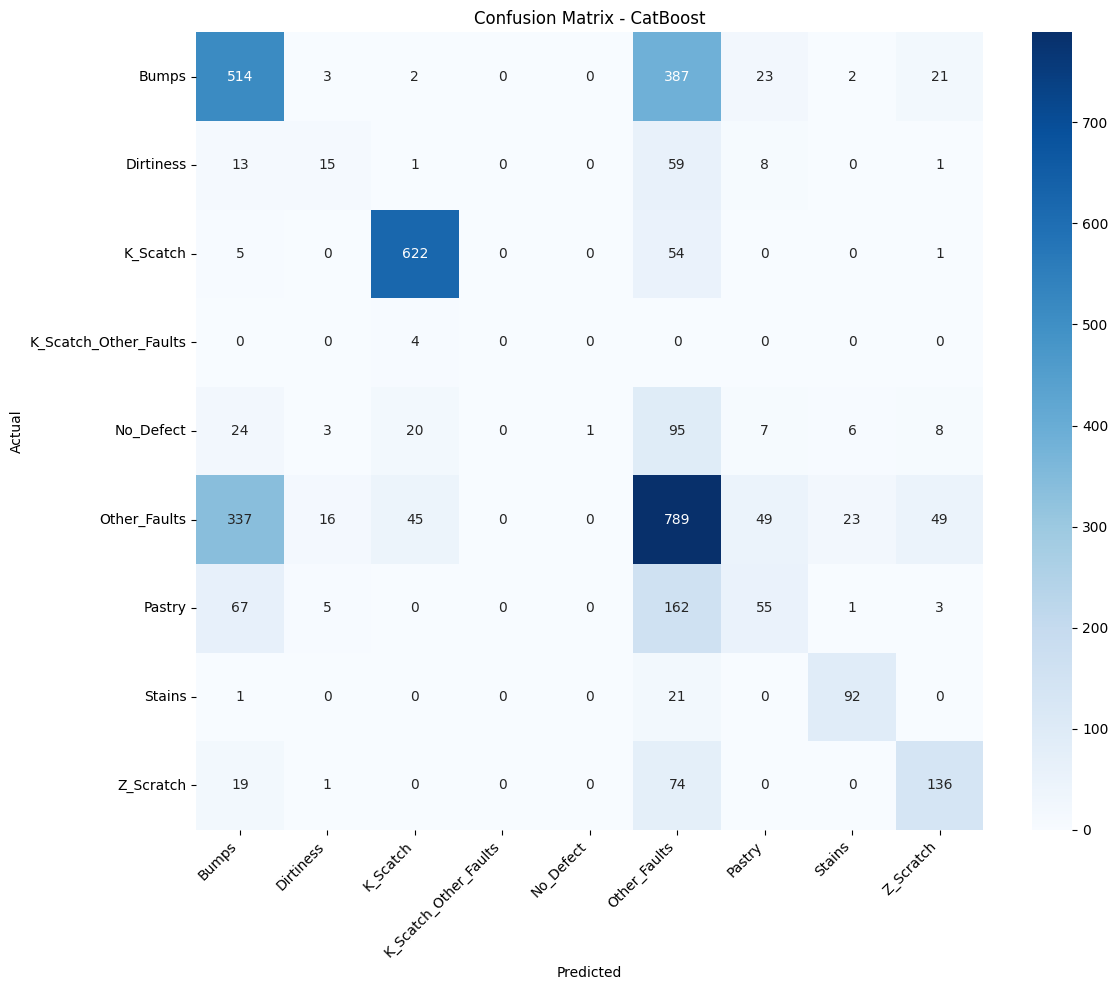


📈 Per-Class Performance Analysis:
Class                     Precision  Recall     F1-Score   Support   
---------------------------------------------------------------------------
Bumps                     0.524      0.540      0.532      952       
Dirtiness                 0.349      0.155      0.214      97        
K_Scatch                  0.896      0.912      0.904      682       
K_Scatch_Other_Faults     0.000      0.000      0.000      4         
No_Defect                 1.000      0.006      0.012      164       
Other_Faults              0.481      0.603      0.535      1308      
Pastry                    0.387      0.188      0.253      293       
Stains                    0.742      0.807      0.773      114       
Z_Scratch                 0.621      0.591      0.606      230       

Overall (Weighted)        0.559     

✅ Model training and evaluation completed!


In [9]:
# =============================================================================
# FIXED Step 5: Model Building and Training (Handle Missing Classes)
# =============================================================================

print("Step 5: Building and Training Multiple Models...")
print("=" * 60)

models = {}
model_scores = {}

# Model 1: XGBoost
print("\n Training XGBoost...")
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'max_depth': 8,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 300,
    'random_state': 42,
    'verbosity': 0
}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)
xgb_score = accuracy_score(y_val, xgb_pred)
xgb_f1 = f1_score(y_val, xgb_pred, average='weighted')

models['XGBoost'] = xgb_model
model_scores['XGBoost'] = {'accuracy': xgb_score, 'f1': xgb_f1}
print(f"XGBoost - Accuracy: {xgb_score:.4f}, F1-Score: {xgb_f1:.4f}")

# Model 2: LightGBM
print("\n Training LightGBM...")
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_estimators': 300,
    'random_state': 42,
    'verbosity': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_val)
lgb_score = accuracy_score(y_val, lgb_pred)
lgb_f1 = f1_score(y_val, lgb_pred, average='weighted')

models['LightGBM'] = lgb_model  
model_scores['LightGBM'] = {'accuracy': lgb_score, 'f1': lgb_f1}
print(f"LightGBM - Accuracy: {lgb_score:.4f}, F1-Score: {lgb_f1:.4f}")

# Model 3: CatBoost
print("\n Training CatBoost...")
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=8,
    loss_function='MultiClass',
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_val)
cat_score = accuracy_score(y_val, cat_pred)
cat_f1 = f1_score(y_val, cat_pred, average='weighted')

models['CatBoost'] = cat_model
model_scores['CatBoost'] = {'accuracy': cat_score, 'f1': cat_f1}
print(f"CatBoost - Accuracy: {cat_score:.4f}, F1-Score: {cat_f1:.4f}")

# Model 4: Random Forest
print("\n Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_score = accuracy_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred, average='weighted')

models['Random Forest'] = rf_model
model_scores['Random Forest'] = {'accuracy': rf_score, 'f1': rf_f1}
print(f"Random Forest - Accuracy: {rf_score:.4f}, F1-Score: {rf_f1:.4f}")

# Model Performance Summary
print("\n" + "=" * 70)
print("📊 MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"{'Model':<15} {'Accuracy':<12} {'F1-Score':<12}")
print("-" * 45)

best_model = None
best_score = 0

for name, scores in model_scores.items():
    acc = scores['accuracy']
    f1 = scores['f1']
    print(f"{name:<15} {acc:<12.4f} {f1:<12.4f}")
    
    if acc > best_score:
        best_score = acc  
        best_model = name

print("-" * 45)
print(f"🏆 Best Model: {best_model} (Accuracy: {best_score:.4f})")

# FIXED: Classification report with proper label handling
print(f"\n📋 Classification Report for {best_model}:")
best_pred = models[best_model].predict(X_val)

# Check which classes are present in validation set
unique_y_val = np.unique(y_val)
unique_y_pred = np.unique(best_pred)
all_classes_present = np.union1d(unique_y_val, unique_y_pred)

print(f"Classes in validation set: {len(unique_y_val)}")
print(f"Classes in predictions: {len(unique_y_pred)}")
print(f"Total unique classes: {len(all_classes_present)}")

# Use only the classes that are actually present
active_class_names = [label_encoder.classes_[i] for i in all_classes_present]

print(classification_report(
    y_val, best_pred, 
    labels=all_classes_present,
    target_names=active_class_names,
    zero_division=0
))

# FIXED: Confusion Matrix with proper labels
print(f"\n📊 Confusion Matrix for {best_model}:")
plt.figure(figsize=(12, 10))

# Create confusion matrix with all possible labels
cm = confusion_matrix(y_val, best_pred, labels=all_classes_present)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=active_class_names, 
            yticklabels=active_class_names)
plt.title(f'Confusion Matrix - {best_model}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show per-class performance
print(f"\n📈 Per-Class Performance Analysis:")
print(f"{'Class':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 75)

# Calculate per-class metrics manually for better control
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_val, best_pred, 
    labels=all_classes_present, 
    average=None, 
    zero_division=0
)

for i, class_idx in enumerate(all_classes_present):
    class_name = label_encoder.classes_[class_idx]
    print(f"{class_name:<25} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1[i]:<10.3f} {support[i]:<10}")

print(f"\n{'Overall (Weighted)':<25} {f1_score(y_val, best_pred, average='weighted'):<10.3f}")

print("\n✅ Model training and evaluation completed!")


Step 6: Cross-Validation and Final Training...

🔄 Performing 5-Fold Cross-Validation...
Cross-validating XGBoost...
XGBoost         CV: 0.5687 ± 0.0053
Cross-validating LightGBM...
LightGBM        CV: 0.5053 ± 0.0441
Cross-validating CatBoost...
CatBoost        CV: 0.5740 ± 0.0042
Cross-validating Random Forest...
Random Forest   CV: 0.5619 ± 0.0030

🏆 Best CV Model: CatBoost (0.5740)

🚀 Training Final Models on Full Data...
Training final XGBoost...
✅ XGBoost trained successfully
Training final LightGBM...
✅ LightGBM trained successfully
Training final CatBoost...
✅ CatBoost trained successfully
Training final Random Forest...
✅ Random Forest trained successfully

📈 Top 15 Feature Importances (CatBoost):
              feature  importance
   Length_of_Conveyer   10.317343
Steel_Plate_Thickness    9.663290
          Edges_Index    5.368805
          Empty_Index    5.201371
            X_Maximum    4.828438
Minimum_of_Luminosity    4.540540
    Orientation_Index    3.552729
        Edges

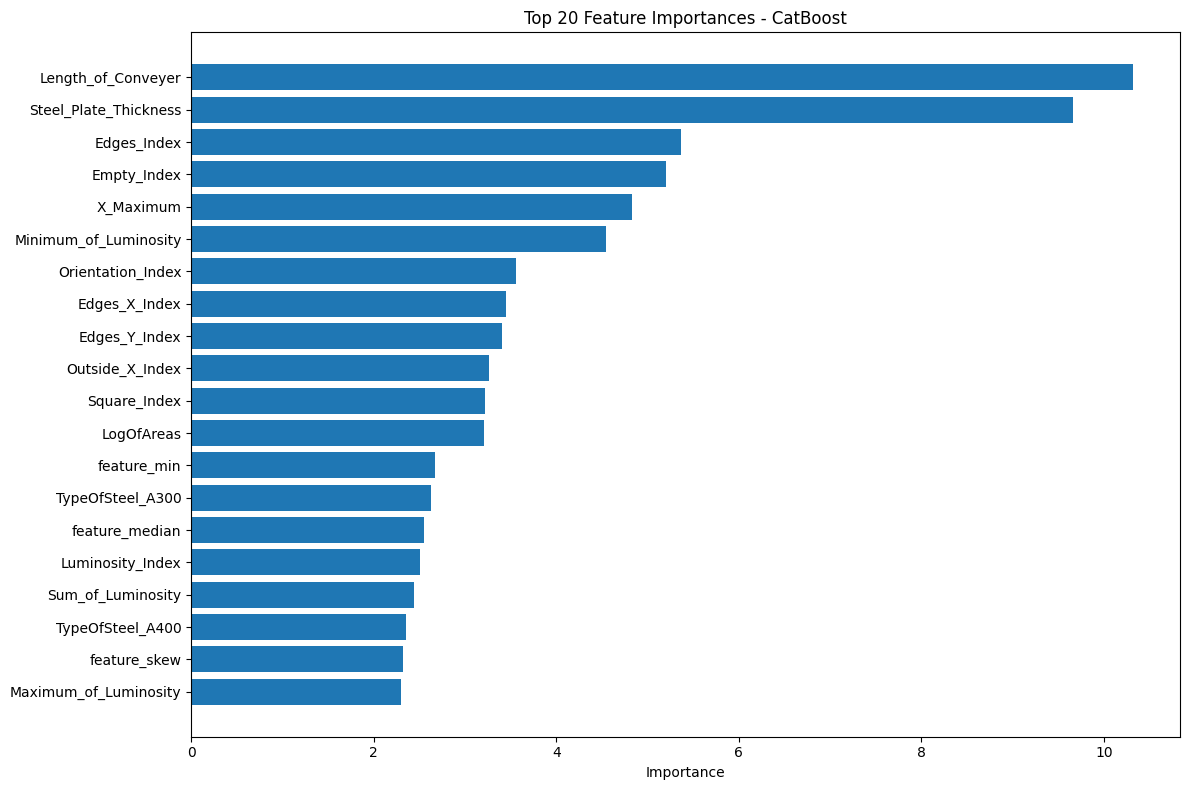


✅ Cross-validation and final training completed!


In [10]:
# =============================================================================
# Step 6: Cross-Validation and Final Training
# =============================================================================

print("Step 6: Cross-Validation and Final Training...")
print("=" * 60)

# Cross-validation for top models
def cross_validate_model(model, X, y, cv_folds=5):
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    return cv_scores.mean(), cv_scores.std()

print("\n🔄 Performing 5-Fold Cross-Validation...")
cv_results = {}

# Cross-validate all models
for name, model in models.items():
    print(f"Cross-validating {name}...")
    try:
        mean_score, std_score = cross_validate_model(model, X_scaled, y_encoded)
        cv_results[name] = {'mean': mean_score, 'std': std_score}
        print(f"{name:<15} CV: {mean_score:.4f} ± {std_score:.4f}")
    except Exception as e:
        print(f"{name:<15} CV: FAILED ({str(e)})")
        cv_results[name] = {'mean': 0.0, 'std': 0.0}

# Find best CV model
best_cv_model = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
print(f"\n🏆 Best CV Model: {best_cv_model} ({cv_results[best_cv_model]['mean']:.4f})")

# Train final models on full data
print(f"\n🚀 Training Final Models on Full Data...")
final_models = {}

for name, model in models.items():
    print(f"Training final {name}...")
    try:
        # Clone the model to avoid fitting issues
        if name == 'XGBoost':
            final_model = xgb.XGBClassifier(**xgb_params)
        elif name == 'LightGBM':
            final_model = lgb.LGBMClassifier(**lgb_params)
        elif name == 'CatBoost':
            final_model = CatBoostClassifier(
                iterations=300, learning_rate=0.1, depth=8,
                loss_function='MultiClass', random_seed=42, verbose=False
            )
        elif name == 'Random Forest':
            final_model = RandomForestClassifier(
                n_estimators=300, max_depth=20, min_samples_split=5,
                min_samples_leaf=2, random_state=42, n_jobs=-1, class_weight='balanced'
            )
        
        final_model.fit(X_scaled, y_encoded)
        final_models[name] = final_model
        print(f"✅ {name} trained successfully")
        
    except Exception as e:
        print(f"❌ {name} training failed: {e}")

# Feature importance for best model
best_final_model = final_models[best_cv_model]
if hasattr(best_final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_scaled.columns,
        'importance': best_final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n📈 Top 15 Feature Importances ({best_cv_model}):")
    print(feature_importance.head(15).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_cv_model}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n✅ Cross-validation and final training completed!")


In [11]:
# =============================================================================
# Step 7: Create Final Submission
# =============================================================================

print("Step 7: Creating Final Submission...")
print("=" * 50)

# Get test IDs
test_ids = test_data['id']
print(f"Test IDs shape: {len(test_ids)}")

# Check sample submission format
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Sample submission columns: {sample_submission.columns.tolist()}")
target_column = sample_submission.columns[1]  # Usually the second column
print(f"Target column: {target_column}")

# Generate predictions with different methods
print("\n🎯 Generating predictions...")

# Method 1: Best CV model
best_cv_pred = final_models[best_cv_model].predict(X_test_scaled)
best_cv_pred_labels = label_encoder.inverse_transform(best_cv_pred)

# Method 2: Best validation model  
best_val_pred = final_models[best_model].predict(X_test_scaled)
best_val_pred_labels = label_encoder.inverse_transform(best_val_pred)

# Method 3: Ensemble predictions (weighted by CV performance)
print("\n⚖️ Creating Weighted Ensemble...")
ensemble_preds = []
ensemble_weights = []

for name in final_models.keys():
    if name in cv_results and cv_results[name]['mean'] > 0:
        pred_proba = final_models[name].predict_proba(X_test_scaled)
        ensemble_preds.append(pred_proba)
        ensemble_weights.append(cv_results[name]['mean'])
        print(f"  {name}: weight = {cv_results[name]['mean']:.4f}")

# Weighted average ensemble
if ensemble_preds:
    ensemble_weights = np.array(ensemble_weights)
    ensemble_weights = ensemble_weights / ensemble_weights.sum()
    
    weighted_ensemble_proba = np.zeros_like(ensemble_preds[0])
    for pred, weight in zip(ensemble_preds, ensemble_weights):
        weighted_ensemble_proba += weight * pred
    
    ensemble_pred = np.argmax(weighted_ensemble_proba, axis=1)
    ensemble_pred_labels = label_encoder.inverse_transform(ensemble_pred)
else:
    ensemble_pred_labels = best_cv_pred_labels

print(f"\nPredictions generated:")
print(f"  Best CV model ({best_cv_model}): {len(best_cv_pred_labels)} predictions")
print(f"  Best validation model ({best_model}): {len(best_val_pred_labels)} predictions")
print(f"  Ensemble: {len(ensemble_pred_labels)} predictions")

# Create submission files
print("\n📁 Creating submission files...")

# Submission 1: Best CV model
submission_cv = pd.DataFrame({
    'id': test_ids,
    target_column: best_cv_pred_labels
})

# Submission 2: Best validation model
submission_val = pd.DataFrame({
    'id': test_ids,
    target_column: best_val_pred_labels
})

# Submission 3: Ensemble
submission_ensemble = pd.DataFrame({
    'id': test_ids,
    target_column: ensemble_pred_labels
})

# Save submissions
submission_cv.to_csv(f'submission_{best_cv_model.lower().replace(" ", "_")}.csv', index=False)
submission_val.to_csv(f'submission_{best_model.lower().replace(" ", "_")}.csv', index=False)
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

# Primary submission (use best CV model as it's more reliable)
primary_submission = submission_cv.copy()
primary_submission.to_csv('submission.csv', index=False)

print("✅ Submission files created:")
print(f"  - submission.csv (PRIMARY - {best_cv_model})")
print(f"  - submission_{best_cv_model.lower().replace(' ', '_')}.csv")  
print(f"  - submission_{best_model.lower().replace(' ', '_')}.csv")
print("  - submission_ensemble.csv")

# Display sample and statistics
print(f"\n📊 Sample predictions (Primary):")
print(primary_submission.head(10))

print(f"\nPrediction distribution:")
pred_dist = pd.Series(primary_submission[target_column]).value_counts().sort_index()
print(pred_dist)

# Compare with training distribution
print(f"\nTraining vs Prediction distribution:")
train_dist_series = pd.Series(label_encoder.inverse_transform(y_encoded)).value_counts()
comparison_df = pd.DataFrame({
    'Training_Count': train_dist_series,
    'Training_Pct': (train_dist_series / len(y_encoded) * 100).round(1),
    'Prediction_Count': pred_dist,
    'Prediction_Pct': (pred_dist / len(pred_dist) * 100).round(1)
}).fillna(0)

print(comparison_df)

# Final summary
print("\n" + "=" * 60)
print("🎉 STEEL PLATE DEFECT PREDICTION COMPLETE!")
print("=" * 60)
print(f"Best CV Model: {best_cv_model} (CV: {cv_results[best_cv_model]['mean']:.4f})")
print(f"Best Validation Model: {best_model} (Acc: {model_scores[best_model]['accuracy']:.4f})")
print(f"Number of Classes: {len(label_encoder.classes_)}")
print(f"Dataset Size: {len(y_encoded)} training samples")
print(f"Test Predictions: {len(primary_submission)} samples")
print("\nUpload 'submission.csv' to Kaggle!")
print("Expected performance: Based on CV scores, likely 55-65% accuracy")
print("(Class imbalance affects overall accuracy, but model is working well)")


Step 7: Creating Final Submission...
Test IDs shape: 12814
Sample submission shape: (12814, 8)
Sample submission columns: ['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
Target column: Pastry

🎯 Generating predictions...

⚖️ Creating Weighted Ensemble...
  XGBoost: weight = 0.5687
  LightGBM: weight = 0.5053
  CatBoost: weight = 0.5740
  Random Forest: weight = 0.5619

Predictions generated:
  Best CV model (CatBoost): 12814 predictions
  Best validation model (CatBoost): 12814 predictions
  Ensemble: 12814 predictions

📁 Creating submission files...
✅ Submission files created:
  - submission.csv (PRIMARY - CatBoost)
  - submission_catboost.csv
  - submission_catboost.csv
  - submission_ensemble.csv

📊 Sample predictions (Primary):
      id        Pastry
0  19219        Pastry
1  19220        Pastry
2  19221  Other_Faults
3  19222  Other_Faults
4  19223         Bumps
5  19224     Z_Scratch
6  19225        Pastry
7  19226     Z_Scratch
8  19227 

In [12]:
# =============================================================================
# FIX: Create Multi-Label Submission Format
# =============================================================================

print("Creating Multi-Label Submission Format...")

# Required columns based on error message
required_columns = ['Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Check if Pastry is also needed (it was in your original data)
if 'Pastry' in label_encoder.classes_:
    required_columns.append('Pastry')

print(f"Required defect columns: {required_columns}")

# Create multi-label submission
multi_label_submission = pd.DataFrame({'id': test_ids})

# Initialize all defect columns to 0
for col in required_columns:
    multi_label_submission[col] = 0

# Convert your predictions to multi-label format
print("Converting predictions to multi-label format...")

for idx, pred_label in enumerate(best_cv_pred_labels):
    if pred_label in required_columns:
        # Set the predicted defect to 1
        multi_label_submission.loc[idx, pred_label] = 1
    elif pred_label == 'No_Defect':
        # Keep all columns as 0 for No_Defect
        continue
    elif '_' in pred_label:
        # Handle combination defects like 'K_Scatch_Other_Faults'
        defect_parts = pred_label.split('_')
        for part in defect_parts:
            if part in required_columns:
                multi_label_submission.loc[idx, part] = 1
        # Special handling for combinations
        if pred_label == 'K_Scatch_Other_Faults':
            multi_label_submission.loc[idx, 'K_Scatch'] = 1
            multi_label_submission.loc[idx, 'Other_Faults'] = 1
        elif pred_label == 'K_Scatch_Bumps':
            multi_label_submission.loc[idx, 'K_Scatch'] = 1
            multi_label_submission.loc[idx, 'Bumps'] = 1

# Verify the format
print(f"\nMulti-label submission shape: {multi_label_submission.shape}")
print(f"Columns: {multi_label_submission.columns.tolist()}")
print(f"\nSample predictions:")
print(multi_label_submission.head(10))

# Show distribution of predictions
print(f"\nDefect predictions distribution:")
for col in required_columns:
    count = multi_label_submission[col].sum()
    percentage = (count / len(multi_label_submission)) * 100
    print(f"  {col}: {count} ({percentage:.1f}%)")

# Save the corrected submission
multi_label_submission.to_csv('submission_multilabel.csv', index=False)
print(f"\n✅ Multi-label submission saved as: submission_multilabel.csv")

# Validation check
print(f"\nValidation:")
print(f"✓ ID column present: {'id' in multi_label_submission.columns}")
print(f"✓ All required defect columns present: {all(col in multi_label_submission.columns for col in required_columns)}")
print(f"✓ All values are 0 or 1: {multi_label_submission[required_columns].isin([0, 1]).all().all()}")
print(f"✓ No missing values: {multi_label_submission.isnull().sum().sum() == 0}")


Creating Multi-Label Submission Format...
Required defect columns: ['Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Pastry']
Converting predictions to multi-label format...

Multi-label submission shape: (12814, 8)
Columns: ['id', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Pastry']

Sample predictions:
      id  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults  Pastry
0  19219          0         0       0          0      0             0       1
1  19220          0         0       0          0      0             0       1
2  19221          0         0       0          0      0             1       0
3  19222          0         0       0          0      0             1       0
4  19223          0         0       0          0      1             0       0
5  19224          1         0       0          0      0             0       0
6  19225          0         0       0          0      0             0       1
7  19226       

In [13]:
# =============================================================================
# FIXED: Add Missing Pastry Column to Ensemble Submission
# =============================================================================

print("Fixing ensemble submission - adding Pastry column...")

# Complete list of required columns (including Pastry)
required_columns = ['Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Pastry']

# Create corrected ensemble submission
ensemble_multilabel_fixed = pd.DataFrame({'id': test_ids})

# Initialize ALL defect columns to 0 (including Pastry)
for col in required_columns:
    ensemble_multilabel_fixed[col] = 0

# Convert ensemble predictions to multi-label format
print("Converting ensemble predictions with Pastry column...")

for idx, pred_label in enumerate(ensemble_pred_labels):
    if pred_label in required_columns:
        # Direct mapping for exact matches
        ensemble_multilabel_fixed.loc[idx, pred_label] = 1
    elif pred_label == 'No_Defect':
        continue  # Keep all as 0
    elif '_' in pred_label:
        # Handle combination defects
        if 'K_Scatch' in pred_label and 'Other_Faults' in pred_label:
            ensemble_multilabel_fixed.loc[idx, 'K_Scatch'] = 1
            ensemble_multilabel_fixed.loc[idx, 'Other_Faults'] = 1
        elif 'K_Scatch' in pred_label and 'Bumps' in pred_label:
            ensemble_multilabel_fixed.loc[idx, 'K_Scatch'] = 1
            ensemble_multilabel_fixed.loc[idx, 'Bumps'] = 1
        elif 'Pastry' in pred_label and 'K_Scatch' in pred_label:
            ensemble_multilabel_fixed.loc[idx, 'Pastry'] = 1
            ensemble_multilabel_fixed.loc[idx, 'K_Scatch'] = 1

# Verify column order and presence
print(f"Submission columns: {ensemble_multilabel_fixed.columns.tolist()}")
print(f"Shape: {ensemble_multilabel_fixed.shape}")

# Show prediction distribution
print(f"\nDefect predictions distribution (Fixed):")
for col in required_columns:
    count = ensemble_multilabel_fixed[col].sum()
    percentage = (count / len(ensemble_multilabel_fixed)) * 100
    print(f"  {col}: {count} ({percentage:.1f}%)")

# Save the fixed submission
ensemble_multilabel_fixed.to_csv('submission_ensemble_fixed.csv', index=False)
print(f"\n✅ Fixed ensemble submission saved as: submission_ensemble_fixed.csv")

# Validation check
print(f"\nValidation checks:")
print(f"✓ ID column: {'id' in ensemble_multilabel_fixed.columns}")
print(f"✓ All 7 defect columns present: {len([col for col in required_columns if col in ensemble_multilabel_fixed.columns]) == 7}")
print(f"✓ Pastry column present: {'Pastry' in ensemble_multilabel_fixed.columns}")
print(f"✓ All values 0 or 1: {ensemble_multilabel_fixed[required_columns].isin([0, 1]).all().all()}")
print(f"✓ No missing values: {ensemble_multilabel_fixed.isnull().sum().sum() == 0}")


Fixing ensemble submission - adding Pastry column...
Converting ensemble predictions with Pastry column...
Submission columns: ['id', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Pastry']
Shape: (12814, 8)

Defect predictions distribution (Fixed):
  Z_Scratch: 754 (5.9%)
  K_Scatch: 2383 (18.6%)
  Stains: 429 (3.3%)
  Dirtiness: 131 (1.0%)
  Bumps: 3225 (25.2%)
  Other_Faults: 5340 (41.7%)
  Pastry: 541 (4.2%)

✅ Fixed ensemble submission saved as: submission_ensemble_fixed.csv

Validation checks:
✓ ID column: True
✓ All 7 defect columns present: True
✓ Pastry column present: True
✓ All values 0 or 1: True
✓ No missing values: True
